# Data Collection using resource enabled client

In [1]:
# Import package
import requests
import urllib
import base64
import datetime
from urllib.parse import urlencode
from collections import OrderedDict
import json
import re


In [2]:
# Set client credentials 
client_id = 'b0c2cf15a3a84fdfbe5b4c93e869eb71'
client_secret = '3302cc59d1d441adb70dfb323054bd1a'

In [3]:
class SpotifyAPI(object):
    access_token = None
    access_token_expires = datetime.datetime.now()
    access_token_did_expire = True
    client_id = None
    client_secret = None
    token_url = 'https://accounts.spotify.com/api/token'
    
    def __init__(self, client_id, client_secret, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.client_id = client_id
        self.client_secret = client_secret
        
    def get_client_credentials(self):
        """
        Returnes a base64 encoded string
        """
        client_id = self.client_id
        client_secret = self.client_secret
        if client_secret == None or client_id == None:
            raise Exception('You must set client_id and client_secret')
        client_creds = f'{client_id}:{client_secret}'
        client_creds_b64 = base64.b64encode(client_creds.encode())
        return client_creds_b64.decode()
    
    def get_token_headers(self):
        client_creds_64 = self.get_client_credentials()
        return {
            'Authorization': f'Basic {client_creds_64}' 
        }
 
    def get_token_data(self):
        return {
            'grant_type': 'client_credentials'
        }
    def perform_auth(self):
        token_url = self.token_url
        token_data = self.get_token_data()
        token_headers = self.get_token_headers()
        r = requests.post(token_url, data=token_data, headers=token_headers)
        if r.status_code not in range(200,299):
            raise Exception('Could not authenticate client.')
            #return False
        data = r.json()
        now = datetime.datetime.now()
        access_token = data['access_token']
        expires_in = data['expires_in'] # seconds
        expires = now + datetime.timedelta(seconds=expires_in)
        self.access_token = access_token
        self.access_token_expires = expires
        self.access_token_did_expire = expires < now 
        return True
    
    def get_access_token(self):
        token = self.access_token
        expires = self.access_token_expires
        now = datetime.datetime.now()
        if expires < now:
            self.perform_auth()
            return self.get_access_token()
        elif token == None:
            self.perfom_auth()
            return self.get_access_token()  
        return token
    
    def get_resource_header(self):
        access_token = self.get_access_token()
        headers = {
            'Authorization': f'Bearer {access_token}'
        }
        return headers
    
    def get_resource(self,lookup_id, resource_type='albums', version='v1'):
        end_point = f'https://api.spotify.com/{version}/{resource_type}/{lookup_id}'
        headers = self.get_resource_header()
        r = requests.get(end_point, headers=headers)
        if r.status_code not in range(200, 299):
            return {}
        return r.json()
        
    def get_album(self, _id):
        return self.get_resource(_id, resource_type='albums')
    
    def get_artist(self, _id):
        return self.get_resource(_id, resource_type='artists')
    
    def base_search(self, query_params):
        headers = self.get_resource_header()
        endpoint = 'https://api.spotify.com/v1/search'
        lookup_url = f'{endpoint}?{query_params}'
        r = requests.get(lookup_url, headers=headers)
        if r.status_code not in range(200, 299):
            return {}
        return r.json()
    
    def search(self, query=None, operator=None, operator_query=None, search_type='artist'):
        if query == None:
            raise Exception('A query is required')
        if isinstance(query, dict):
            query = ' '.join([f'{k}:{v}' for k,v in query.items()])
        if operator != None and operator_query != None:
            if operator.lower() == 'or' or operator.lower() == 'not':
                operator = operator.upper()
                if isinstance(operator_query, str):
                    query = f'{query} {operator} {operator_query}'
        query_params = urlencode({'q':query, 'type':search_type.lower()})
        return self.base_search(query_params)

In [4]:
spotify = SpotifyAPI(client_id, client_secret)

In [5]:
genres = ['African heavy metal', 'African hip hop', 'Afro-soul', 'Afrobeat', 
          'Afrobeats', 'Afro house', 'Amapiano', 'Apala', 'Azonto', 
          'Batuque', 'Benga', 'Bikutsi', 'Bongo Flava', 'Cape Jazz', 'Chimurenga', 
          'Coladeira', 'Coupé-Décalé', 'Fuji', 'Funaná', 'Genge', 'Gengeton', 'Gqom', 
          'Highlife', 'Hipco', 'Hiplife', 'Isicathamiya', 'Jit', 'Jùjú', 'Kapuka', 
          'Boomba', 'Kalindula', 'Kilalaky', 'Kizomba', 'Kuduro', 'Kwaito', 'Kwela', 
          'Makossa', 'Maloya', 'Marrabenta', 'Mbalax', 'Mbaqanga', 'Mbube', 'Morna', 
          'Museve', 'Ndombolo', 'Ogene', 'Palm-wine', 'Maringa', 'Pandza', 'Raï', 
          'Sakara', 'Salegy', 'Sega', 'Semba', 'Shangaan electro', 'Soukous', 'African rumba', 
          'Sudanese', 'Sungura', 'Taarab']

In [6]:
offset = 1000

# list of tuples containing song title, (id, and popularity)
tracks = []

# Each API request returns 20
# Get top 20, then offset of 1000 to get bottom 20 from each genre

# We can vary popularity either through offset or depth of genre
# at 5000 offset, most popularity < 10
# at genres[300:], most popularity < 60
# at genres[1000:], most popularity < 10

# some deep genres don't have results for offset 1000, so the set of tracks won't be as long
# as the math suggests

# helper function to display track list
def printTracks(tracks):
    for (name, (id, pop)) in tracks:
         print(name, id, pop)

i = 0
for genre in genres:
    headers = spotify.get_resource_header()
    
    # get top 20 songs from the genre
    url = "https://api.spotify.com/v1/search?q=year:2021%20genre:{0}&type=track".format(genre)    
    top = requests.get(url, headers=headers).json()
    
    # get bottom 10 using offset
    url = url + "&offset={0}".format(offset)
    bottom = requests.get(url, headers=headers).json()
    
    # use a try except block to avoid errors if the search result is empty
    try:
        for track in top["tracks"]["items"]:
            tracks.append((track["name"], (track["id"], track["popularity"])))
        for track in bottom["tracks"]["items"]:
            tracks.append((track["name"], (track["id"], track["popularity"])))   
    except Exception:
        pass 
    i += 1

trackSet = list(OrderedDict(tracks[::-1]).items())[::-1]

In [7]:
# create a dataframe
import pandas

columns = ["name", "id", "popularity", "acousticness", "danceability", 
           "duration_ms", "energy", "instrumentalness", "key", "liveness",
          "loudness", "mode", "speechiness", "tempo", "time_signature",
          "valence"]

features = pandas.DataFrame(columns=columns)

for (name, (id, pop)) in trackSet:
    features = features.append({"name": name, "id": id, "popularity": pop}, ignore_index=True)

i = 0

# loop through chunks of 100 tracks, using an iterator 
while i < features.shape[0]:
    headers = spotify.get_resource_header()
    
    # create a comma separated string of all the track ids, which is required
    # for the spotify api call
    idString = ""
    for id in features.loc[i:i+99, "id"]:
        idString += id + ","
        
    # remove the final comma
    idString = idString[:-1]
        
    # get a list of 100 track features objects
    url = "https://api.spotify.com/v1/audio-features/?ids=%s" % idString 

    result = requests.get(url, headers=headers).json()
    featuresObjects = result["audio_features"]
    
    # set this chunk of 100 feature items to the results
    for feature in columns[3:]:
        features.loc[i:i+99, feature] = [featuresObject[feature] for featuresObject in featuresObjects]
    
    i += 100
    

In [8]:
features.head()

,name,id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,Practice,1EGFWhKTudG7hMYEO08vkX,18,0.0458,0.769,230947,0.669,0.000004,2,0.105,-5.664,1,0.238,79.593,4,0.616
1,HipnWidIt,0GLkLJPMBrs102B7gJqPkw,0,0.00365,0.797,102158,0.438,0.0401,0,0.0473,-8.129,1,0.0801,132.972,3,0.715
2,Who Got The Block Hot?,2YZ69toFfonA4ZYzNM5G5f,0,0.022,0.732,223147,0.622,0.000002,7,0.105,-8.703,1,0.427,190.111,4,0.551
3,King Shit,2d11AqjpXEE5d1TZDUHAxv,1,0.515,0.804,177027,0.261,0,5,0.0937,-10.879,1,0.289,119.917,4,0.262
4,Thoughts,4s02PJCYrD3KGBCekdyLA8,1,0.0208,0.823,331500,0.322,0.000002,1,0.0906,-12.893,1,0.231,160.077,4,0.362


In [9]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 547 entries, 0 to 546
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   name              547 non-null    object
 1   id                547 non-null    object
 2   popularity        547 non-null    object
 3   acousticness      547 non-null    object
 4   danceability      547 non-null    object
 5   duration_ms       547 non-null    object
 6   energy            547 non-null    object
 7   instrumentalness  547 non-null    object
 8   key               547 non-null    object
 9   liveness          547 non-null    object
 10  loudness          547 non-null    object
 11  mode              547 non-null    object
 12  speechiness       547 non-null    object
 13  tempo             547 non-null    object
 14  time_signature    547 non-null    object
 15  valence           547 non-null    object
dtypes: object(16)
memory usage: 68.5+ KB


In [10]:
spot_tracks = features.copy()

In [11]:
spot_tracks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 547 entries, 0 to 546
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   name              547 non-null    object
 1   id                547 non-null    object
 2   popularity        547 non-null    object
 3   acousticness      547 non-null    object
 4   danceability      547 non-null    object
 5   duration_ms       547 non-null    object
 6   energy            547 non-null    object
 7   instrumentalness  547 non-null    object
 8   key               547 non-null    object
 9   liveness          547 non-null    object
 10  loudness          547 non-null    object
 11  mode              547 non-null    object
 12  speechiness       547 non-null    object
 13  tempo             547 non-null    object
 14  time_signature    547 non-null    object
 15  valence           547 non-null    object
dtypes: object(16)
memory usage: 68.5+ KB


## Data Cleaning 

In [12]:
spot_tracks.dtypes

name                object
id                  object
popularity          object
acousticness        object
danceability        object
duration_ms         object
energy              object
instrumentalness    object
key                 object
liveness            object
loudness            object
mode                object
speechiness         object
tempo               object
time_signature      object
valence             object
dtype: object

In [13]:
spot_tracks[['popularity', 'duration_ms', 
                 'key', 'mode', 'time_signature']] = spot_tracks[['popularity', 'duration_ms', 
                                                                      'key', 'mode', 'time_signature']].astype("int")
spot_tracks[['acousticness', 'danceability',
                 'energy', 'instrumentalness', 
                 'liveness', 'loudness', 'tempo', 
                 'valence', 'speechiness']] = spot_tracks[['acousticness', 'danceability', 
                                                               'energy', 'instrumentalness', 
                                                               'liveness', 'loudness', 
                                                               'tempo', 'valence', 'speechiness']].astype("float")

In [14]:
spot_tracks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 547 entries, 0 to 546
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              547 non-null    object 
 1   id                547 non-null    object 
 2   popularity        547 non-null    int64  
 3   acousticness      547 non-null    float64
 4   danceability      547 non-null    float64
 5   duration_ms       547 non-null    int64  
 6   energy            547 non-null    float64
 7   instrumentalness  547 non-null    float64
 8   key               547 non-null    int64  
 9   liveness          547 non-null    float64
 10  loudness          547 non-null    float64
 11  mode              547 non-null    int64  
 12  speechiness       547 non-null    float64
 13  tempo             547 non-null    float64
 14  time_signature    547 non-null    int64  
 15  valence           547 non-null    float64
dtypes: float64(9), int64(5), object(2)
memory us

# Exploratory Data Analysis

In [15]:
new_spot_tracks = spot_tracks.select_dtypes('number')

In [16]:
spot_tracks.corr()

,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
popularity,1.000000,-0.132806,-0.101408,-0.151221,0.041230,0.251436,0.050067,0.199698,-0.303093,-0.140649,-0.043097,-0.191083,0.069992,-0.267149
acousticness,-0.132806,1.000000,-0.100990,-0.003891,-0.347026,-0.183861,-0.012440,-0.051807,0.022115,-0.027284,0.018965,-0.057691,-0.040417,0.068499
danceability,-0.101408,-0.100990,1.000000,-0.004329,-0.070967,-0.327826,-0.010430,-0.391626,0.421641,-0.079326,0.089262,0.006059,0.188054,0.310620
duration_ms,-0.151221,-0.003891,-0.004329,1.000000,-0.037810,-0.016440,0.001136,-0.098713,-0.063790,0.105770,-0.116249,-0.013049,0.040437,0.142446
energy,0.041230,-0.347026,-0.070967,-0.037810,1.000000,0.065494,0.050091,0.213129,0.362014,0.061284,-0.064108,0.057660,-0.084400,0.284828
instrumentalness,0.251436,-0.183861,-0.327826,-0.016440,0.065494,1.000000,0.003702,0.323233,-0.545783,-0.019227,-0.165127,-0.084180,-0.083975,-0.363109
key,0.050067,-0.012440,-0.010430,0.001136,0.050091,0.003702,1.000000,0.036041,-0.005454,-0.156213,0.029772,-0.063317,-0.013384,0.044435
liveness,0.199698,-0.051807,-0.391626,-0.098713,0.213129,0.323233,0.036041,1.000000,-0.366543,0.033247,-0.011566,-0.138921,-0.063598,-0.234847
loudness,-0.303093,0.022115,0.421641,-0.063790,0.362014,-0.545783,-0.005454,-0.366543,1.000000,0.019561,0.017003,0.156217,0.085166,0.442414
mode,-0.140649,-0.027284,-0.079326,0.105770,0.061284,-0.019227,-0.156213,0.033247,0.019561,1.000000,-0.024919,0.024576,-0.087432,0.092405


In [17]:
new_spot_tracks.columns

Index(['popularity', 'acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'key', 'liveness', 'loudness', 'mode',
       'speechiness', 'tempo', 'time_signature', 'valence'],
      dtype='object')

In [18]:
from scipy import stats
for i in new_spot_tracks: 
    pearson_coef, p_value = stats.pearsonr(spot_tracks[i], spot_tracks['popularity'])
    print("-->", "The Pearson Correlation Coefficient of",
          i, "vs popularity is", pearson_coef, 
          " with a P-value of P =", p_value)  

--> The Pearson Correlation Coefficient of popularity vs popularity is 1.0  with a P-value of P = 0.0
--> The Pearson Correlation Coefficient of acousticness vs popularity is -0.13280594648285018  with a P-value of P = 0.0018534489366625858
--> The Pearson Correlation Coefficient of danceability vs popularity is -0.10140819922726246  with a P-value of P = 0.01767145563372979
--> The Pearson Correlation Coefficient of duration_ms vs popularity is -0.15122090555007303  with a P-value of P = 0.00038655218756148535
--> The Pearson Correlation Coefficient of energy vs popularity is 0.041230428535930154  with a P-value of P = 0.33579753196745415
--> The Pearson Correlation Coefficient of instrumentalness vs popularity is 0.2514358039370806  with a P-value of P = 2.4734807368016603e-09
--> The Pearson Correlation Coefficient of key vs popularity is 0.05006688677271271  with a P-value of P = 0.24239539275426353
--> The Pearson Correlation Coefficient of liveness vs popularity is 0.199698213424

In [19]:
spot_tracks.drop(spot_tracks[['name', 'id', 'danceability', 
                              'energy', 'key', 'speechiness', 
                              'time_signature']], axis = 1, inplace = True)

# Model Fitting

In [20]:
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

In [21]:
X = spot_tracks.drop('popularity', axis = 1)
y = spot_tracks.popularity

In [22]:
kf = KFold(shuffle=True, random_state=72018, n_splits=3)

#### Regression Model

In [23]:
estimator = Pipeline([
    ('polynomial_features', PolynomialFeatures()), 
    ('scaler', StandardScaler()), 
    ('linear_regression', LinearRegression())])

params = {
    'polynomial_features__degree': [3]
}

grid = GridSearchCV(estimator, params, cv=kf)

In [24]:
grid.fit(X,y)

GridSearchCV(cv=KFold(n_splits=3, random_state=72018, shuffle=True),
             estimator=Pipeline(steps=[('polynomial_features',
                                        PolynomialFeatures()),
                                       ('scaler', StandardScaler()),
                                       ('linear_regression',
                                        LinearRegression())]),
             param_grid={'polynomial_features__degree': [3]})

In [25]:
grid.best_score_, grid.best_params_

(-3.17412074037062, {'polynomial_features__degree': 3})

In [26]:
y_predict = grid.predict(X)

In [27]:
r2_score(y, y_predict)

0.5837758476278345

In [28]:
lr = grid.best_estimator_.named_steps['linear_regression'].coef_

In [29]:
df_lr = pandas.DataFrame(grid.cv_results_)

In [30]:
importance_coefs = pandas.DataFrame(zip(grid.best_estimator_.named_steps
                                       ['polynomial_features'].get_feature_names(input_features=X.columns),
                                       grid.best_estimator_.named_steps['linear_regression'].coef_))

In [31]:
importance_coefs.rename(columns = {0 : 'Feature names', 1 : 'Coefficients'}, inplace = True)
importance_coefs['Coefficients'] = importance_coefs['Coefficients'].abs()
#importance_coefs = importance_coefs.sort_values(['Coefficients'], ascending=True)
most_importance_coefs = importance_coefs.nlargest(40,'Coefficients')
most_importance_coefs = most_importance_coefs.sort_values(['Coefficients'], ascending=True)

In [32]:
most_importance_coefs 

,Feature names,Coefficients
101,duration_ms loudness tempo,36.527414
78,acousticness tempo^2,36.842552
58,acousticness duration_ms tempo,36.896960
150,loudness mode tempo,36.959970
99,duration_ms loudness^2,37.551059
142,liveness tempo^2,37.839969
158,mode tempo^2,38.915611
25,instrumentalness liveness,39.888790
113,instrumentalness^2 tempo,43.488595
100,duration_ms loudness mode,44.310894


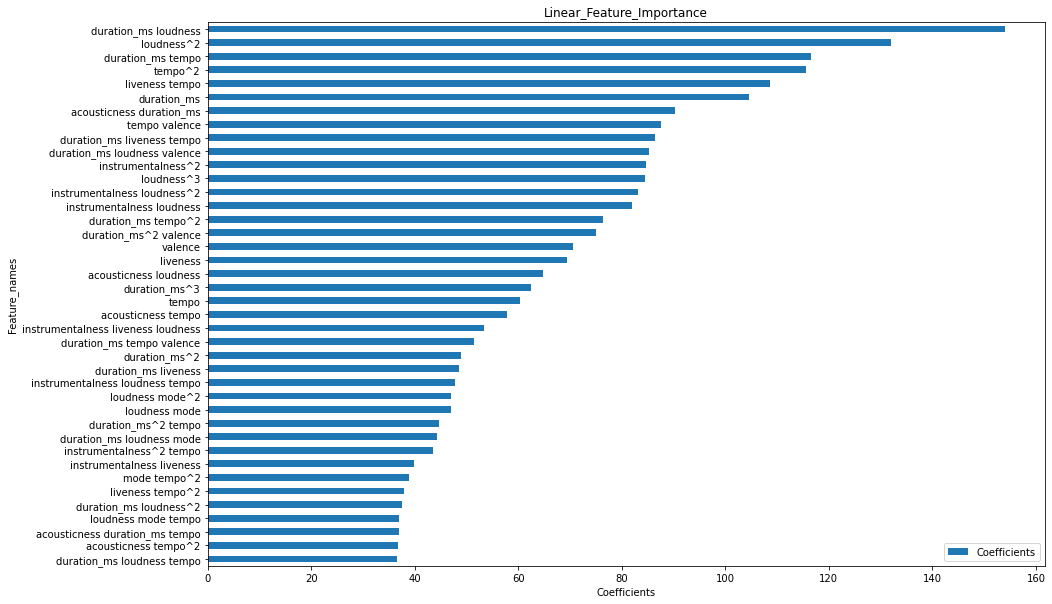

In [33]:
most_importance_coefs.plot.barh(x='Feature names', y='Coefficients', figsize = (15,10))
plt.title('Linear_Feature_Importance')
plt.ylabel('Feature_names')
plt.xlabel('Coefficients')
plt.show()

In [34]:
def rmse(true_y, predicted_y):
    return(mean_squared_error(true_y, predicted_y))

In [35]:
lr_rmse = rmse(y, y_predict)

In [36]:
#importance_coefs = importance_coefs.sort_values(['Coefficients'], ascending=True)

In [37]:
lr_rmse

154.50676111544124

#### Ridge Regression

In [38]:
estimator = Pipeline([
    ('polynomial_features', PolynomialFeatures()), 
    ('scaler', StandardScaler()), 
    ('ridge_regression', Ridge())])

params = {
    'polynomial_features__degree': [1,2,3],
    'ridge_regression__alpha': np.geomspace(1e-15, 20, 30)
}

grid = GridSearchCV(estimator, params, cv=kf)

In [39]:
grid.fit(X,y)

/home/musa/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.10101e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/home/musa/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.0435e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/home/musa/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=9.93073e-19): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/home/musa/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.01696e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/home/musa/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=3.80713e-18

GridSearchCV(cv=KFold(n_splits=3, random_state=72018, shuffle=True),
             estimator=Pipeline(steps=[('polynomial_features',
                                        PolynomialFeatures()),
                                       ('scaler', StandardScaler()),
                                       ('ridge_regression', Ridge())]),
             param_grid={'polynomial_features__degree': [1, 2, 3],
                         'ridge_regression__alpha': array([1.00000000e-15, 3.64841710e-15, 1.33109473e-14, 4.85638879e-14,
       1.77181319e...2, 8.60461371e-12,
       3.13932198e-11, 1.14535560e-10, 4.17873496e-10, 1.52457681e-09,
       5.56229209e-09, 2.02935616e-08, 7.40393771e-08, 2.70126530e-07,
       9.85534250e-07, 3.59564001e-06, 1.31183945e-05, 4.78613748e-05,
       1.74618258e-04, 6.37080240e-04, 2.32433444e-03, 8.48014152e-03,
       3.09390933e-02, 1.12878717e-01, 4.11828642e-01, 1.50252266e+00,
       5.48182937e+00, 2.00000000e+01])})

In [40]:
grid.best_score_, grid.best_params_

(0.29866611375337776,
 {'polynomial_features__degree': 3, 'ridge_regression__alpha': 20.0})

In [41]:
y_predict = grid.predict(X)

In [42]:
r2_score(y, y_predict)

0.4329369136075636

In [43]:
rr = grid.best_estimator_.named_steps['ridge_regression'].coef_

In [44]:
df_rr = pandas.DataFrame(grid.cv_results_)

In [45]:
importance_coefs = pandas.DataFrame(zip(grid.best_estimator_.named_steps
                                       ['polynomial_features'].get_feature_names(input_features=X.columns),
                                       grid.best_estimator_.named_steps['ridge_regression'].coef_))

In [46]:
importance_coefs.rename(columns = {0 : 'Feature names', 1 : 'Coefficients'}, inplace = True)
importance_coefs['Coefficients'] = importance_coefs['Coefficients'].abs()
#importance_coefs = importance_coefs.sort_values(['Coefficients'], ascending=True)
most_importance_coefs = importance_coefs.nlargest(40,'Coefficients')
most_importance_coefs = most_importance_coefs.sort_values(['Coefficients'], ascending=True)

In [47]:
most_importance_coefs 

,Feature names,Coefficients
35,loudness^2,1.665166
132,liveness^2 mode,1.685141
33,liveness tempo,1.689850
114,instrumentalness^2 valence,1.689889
50,acousticness^2 mode,1.700930
56,acousticness duration_ms loudness,1.711865
92,duration_ms instrumentalness tempo,1.716583
19,duration_ms liveness,1.766204
123,instrumentalness loudness valence,1.776722
25,instrumentalness liveness,1.789287


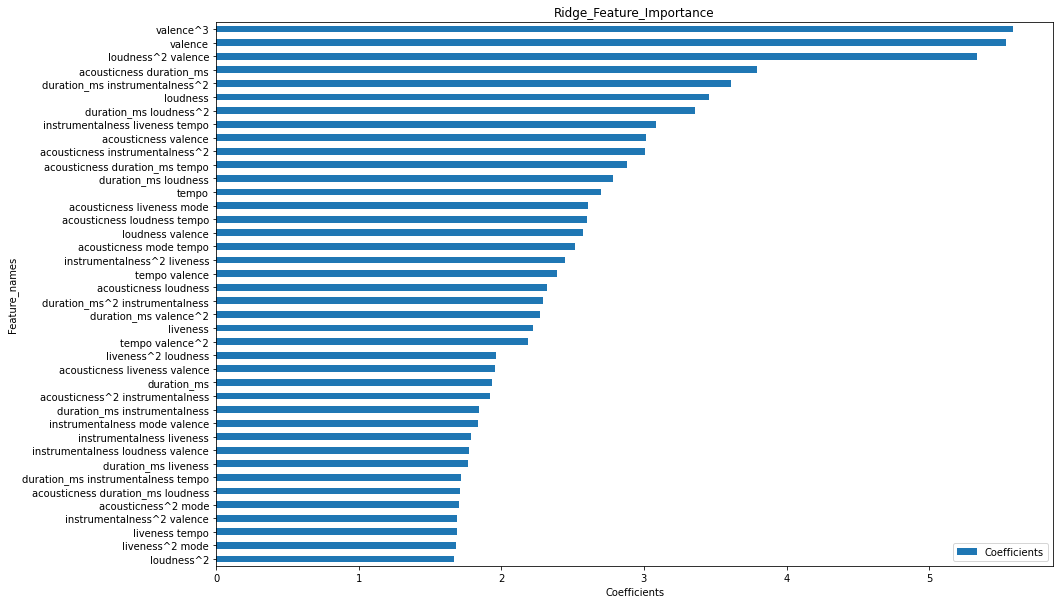

In [48]:
most_importance_coefs.plot.barh(x='Feature names', y='Coefficients', figsize = (15,10))
plt.title('Ridge_Feature_Importance')
plt.ylabel('Feature_names')
plt.xlabel('Coefficients')
plt.show()

In [49]:
rr_rmse = rmse(y, y_predict)
rr_rmse

210.49975194202628

#### Lasso Regression

In [50]:
estimator = Pipeline([
    ('polynomial_features', PolynomialFeatures()), 
    ('scaler', StandardScaler()), 
    ('lasso_regression', Lasso())])

params = {
    'polynomial_features__degree': [1,2,3],
    'lasso_regression__alpha': np.geomspace(1e-15, 10, 10)
}

grid = GridSearchCV(estimator, params, cv=kf)

In [51]:
grid.fit(X,y)

/home/musa/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20099.95218182307, tolerance: 13.726075068493145
  model = cd_fast.enet_coordinate_descent(
/home/musa/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12438.006028297765, tolerance: 13.797382465753426
  model = cd_fast.enet_coordinate_descent(
/home/musa/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 39237.186889319935, tolerance: 13.085229670329673
  model = cd_fast.enet_coordinate_descent(
/home/musa/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desc

/home/musa/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28106.03850078297, tolerance: 13.085229670329673
  model = cd_fast.enet_coordinate_descent(
/home/musa/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26299.83022331854, tolerance: 13.726075068493145
  model = cd_fast.enet_coordinate_descent(
/home/musa/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27187.837411157012, tolerance: 13.797382465753426
  model = cd_fast.enet_coordinate_descent(
/home/musa/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desce

GridSearchCV(cv=KFold(n_splits=3, random_state=72018, shuffle=True),
             estimator=Pipeline(steps=[('polynomial_features',
                                        PolynomialFeatures()),
                                       ('scaler', StandardScaler()),
                                       ('lasso_regression', Lasso())]),
             param_grid={'lasso_regression__alpha': array([1.00000000e-15, 5.99484250e-14, 3.59381366e-12, 2.15443469e-10,
       1.29154967e-08, 7.74263683e-07, 4.64158883e-05, 2.78255940e-03,
       1.66810054e-01, 1.00000000e+01]),
                         'polynomial_features__degree': [1, 2, 3]})

In [52]:
grid.best_score_, grid.best_params_

(0.31031104585769126,
 {'lasso_regression__alpha': 0.16681005372000557,
  'polynomial_features__degree': 3})

In [53]:
y_predict = grid.predict(X)

In [54]:
r2_score(y, y_predict)

0.40556637867685574

In [55]:
las = grid.best_estimator_.named_steps['lasso_regression'].coef_

In [56]:
df_las = pandas.DataFrame(grid.cv_results_)

In [57]:
importance_coefs = pandas.DataFrame(zip(grid.best_estimator_.named_steps
                                       ['polynomial_features'].get_feature_names(input_features=X.columns),
                                       grid.best_estimator_.named_steps['lasso_regression'].coef_))

In [58]:
importance_coefs.rename(columns = {0 : 'Feature names', 1 : 'Coefficients'}, inplace = True)
importance_coefs['Coefficients'] = importance_coefs['Coefficients'].abs()
#importance_coefs = importance_coefs.sort_values(['Coefficients'], ascending=True)
most_importance_coefs = importance_coefs.nlargest(40,'Coefficients')
most_importance_coefs = most_importance_coefs.sort_values(['Coefficients'], ascending=True)

In [59]:
most_importance_coefs 

,Feature names,Coefficients
3,instrumentalness,0.000000
1,acousticness,0.000000
0,1,0.000000
68,acousticness liveness mode,0.042496
72,acousticness loudness mode,0.089148
21,duration_ms mode,0.122369
156,mode^2 tempo,0.278348
84,duration_ms^2 loudness,0.440318
45,acousticness^3,0.469784
32,liveness mode,0.478239


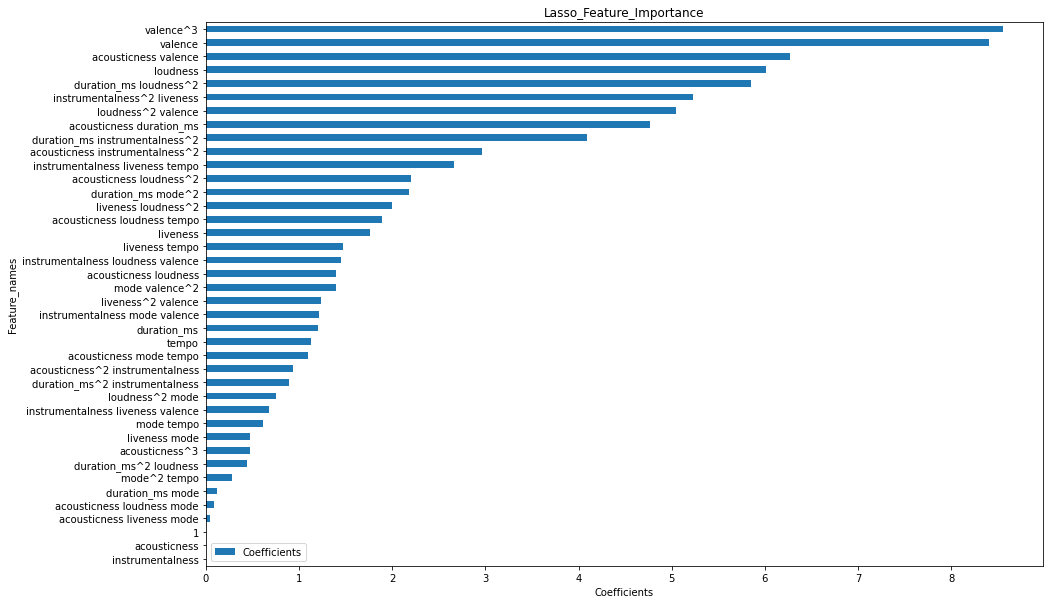

In [60]:
most_importance_coefs.plot.barh(x='Feature names', y='Coefficients', figsize = (15,10))
plt.title('Lasso_Feature_Importance')
plt.ylabel('Feature_names')
plt.xlabel('Coefficients')
plt.show()

In [61]:
las_rmse = rmse(y, y_predict)
las_rmse

220.6599809389237

In [62]:
coefficients = pandas.DataFrame()
coefficients['Linear Regression'] = lr
coefficients['Lasso Regression'] = las
coefficients['Ridge Regression'] = rr
coefficients = coefficients.applymap(abs)

coefficients.describe()

,Linear Regression,Lasso Regression,Ridge Regression
count,1.650000e+02,165.000000,165.000000
mean,2.579946e+01,0.529032,1.099555
std,2.919801e+01,1.470865,1.043380
min,1.406873e-10,0.000000,0.000000
25%,5.959103e+00,0.000000,0.376311
50%,1.455169e+01,0.000000,0.786813
75%,3.469852e+01,0.000000,1.578381
max,1.539654e+02,8.556199,5.589573


In [63]:
(coefficients>0).sum()

Linear Regression    165
Lasso Regression      37
Ridge Regression     164
dtype: int64

In [64]:
import matplotlib.pyplot as plt
import seaborn as sns

In [65]:
coefficients.describe()

,Linear Regression,Lasso Regression,Ridge Regression
count,1.650000e+02,165.000000,165.000000
mean,2.579946e+01,0.529032,1.099555
std,2.919801e+01,1.470865,1.043380
min,1.406873e-10,0.000000,0.000000
25%,5.959103e+00,0.000000,0.376311
50%,1.455169e+01,0.000000,0.786813
75%,3.469852e+01,0.000000,1.578381
max,1.539654e+02,8.556199,5.589573


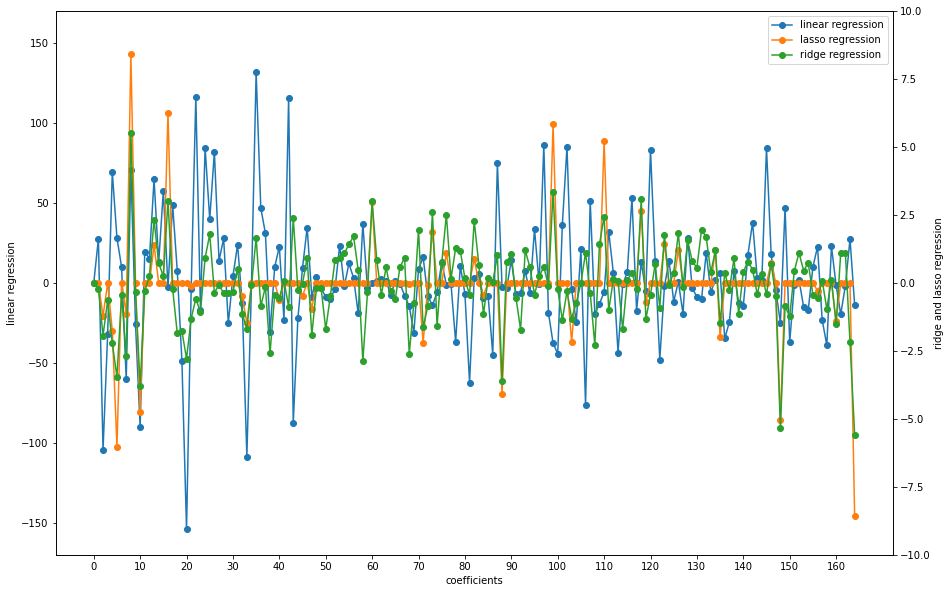

In [66]:
colors = sns.color_palette()

plt.figure(figsize = (15,10))

#Setup the dual y-axis
ax1 = plt.axes()
ax2 = ax1.twinx()

#plot the linear regression data
ax1.plot(lr.ravel(), 
         color=colors[0], marker='o', label='linear regression')

#plot the regularization data
ax2.plot(las.ravel(), 
         color=colors[1], marker='o', label='lasso regression')

ax2.plot(rr.ravel(), 
         color=colors[2], marker='o', label='ridge regression')

#Customize axes scales
ax1.set_ylim(-1.7e+02,1.7e+02)
ax2.set_ylim(-10,10)

#Combine the legends
h1,l1 = ax1.get_legend_handles_labels()
h2,l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2,l1+l2)

ax1.set(xlabel = 'coefficients', ylabel = 'linear regression')
ax2.set(ylabel = 'ridge and lasso regression')

ax1.set_xticks(range(0,165,10))

In [67]:
rmse = pandas.DataFrame({'Model':['Linear Regression', 'Ridge Regression', 'Lasso Regression'], 
                    'Score':[lr_rmse, rr_rmse, las_rmse]})

In [68]:
rmse

,Model,Score
0,Linear Regression,154.506761
1,Ridge Regression,210.499752
2,Lasso Regression,220.659981


# End